Will create data for days 0-750 then fit a forecaster on it to predict logReturns and then export the model and attempt to runin a sim without retraining.

In [30]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

In [31]:
prices1000Days = np.loadtxt("../../sourceCode/1000Prices.txt").T

from strategies.ms_forecasting.main import createGreeksManager
from strategies.ms_forecasting.main import GreeksManager
from strategies.ms_forecasting.main import PRICE_LAGS
from strategies.ms_forecasting.main import MOMENTUM_WINDOWS
from strategies.ms_forecasting.main import VOL_WINDOWS

preTrainingDays = max(PRICE_LAGS + MOMENTUM_WINDOWS + VOL_WINDOWS)

trainingDataWindowSize = 750 - preTrainingDays # 20 days of data needed for all greeks to be void of NaN's
gm: GreeksManager = createGreeksManager(prices1000Days[:, :751], trainingDataWindowSize) # giving 751 days but the 751'st is removed when we get the history

exogIndex = pd.RangeIndex(preTrainingDays, 750)
exogDict = gm.getGreeksHistoryDict(exogIndex)

print("Inst 0 days [742, 750]:\n", prices1000Days[0, 742:750])
display("inst 0 head:", exogDict["inst_0"].tail(1))
print(f"each inst-greek has {len(exogDict["inst_0"]["greek_lag_1"])} days")

Inst 0 days [742, 750]:
 [36.81 36.75 36.53 36.49 36.3  36.58 36.43 36.24]


'inst 0 head:'

,greek_lag_1,greek_lag_2,greek_lag_3,greek_lag_4,greek_lag_5,greek_lag_6,greek_lag_7,greek_volatility_5,greek_volatility_10,greek_volatility_20,greek_momentum_3,greek_momentum_7,greek_momentum_14,greek_momentum_20,greek_price
749,36.43,36.58,36.3,36.49,36.53,36.75,36.81,0.005455,0.004396,0.00372,-0.001654,-0.015606,-0.028562,-0.020214,36.24


each inst-greek has 730 days


In [32]:
logReturnsPricesWindow = prices1000Days[:, preTrainingDays - 1:]
logReturnsNp = np.log(logReturnsPricesWindow[:, 1:] / logReturnsPricesWindow[:, :-1])

logReturnsIndex = pd.RangeIndex(preTrainingDays, 1000)
logReturnsSeries = pd.DataFrame(logReturnsNp.T,
                          index = logReturnsIndex,
                          columns = [f"inst_{i}" for i in range(logReturnsNp.shape[0])])

logReturnsTrainingSeries = logReturnsSeries.iloc[:trainingDataWindowSize]
display(logReturnsTrainingSeries.tail())
display(logReturnsSeries.tail(1))

print("Inst_0:")
priceA = prices1000Days[0, 747]
priceB = prices1000Days[0, 748]
logReturnAToB = np.log(priceB / priceA)
print(f"Price on day 748 = {priceA}")
print(f"Price on day 749 = {priceB}")
print(f"The log return for day 748 = {logReturnAToB}")

,inst_0,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,...,inst_40,inst_41,inst_42,inst_43,inst_44,inst_45,inst_46,inst_47,inst_48,inst_49
745,-0.001096,-0.005633,0.031985,-0.016546,0.002016,-0.016249,0.001678,-0.011669,0.027904,-0.032591,...,0.000932,-0.004909,-0.017300,0.003109,-0.003567,0.004255,0.004442,-0.012935,-0.004282,-0.023199
746,-0.005221,-0.007625,-0.010026,-0.001704,0.003016,-0.003492,-0.002799,-0.008419,-0.009380,-0.008747,...,-0.000932,0.009582,-0.005580,0.021803,0.005544,0.008131,0.001632,-0.013733,-0.013204,0.003799
747,0.007684,-0.002948,-0.009223,-0.005129,0.004007,0.013204,-0.004494,-0.006361,-0.008718,-0.007609,...,-0.001200,0.006969,0.006591,0.011777,0.001052,-0.001297,0.003139,-0.006305,0.005327,0.005671
748,-0.004109,0.007648,-0.005211,-0.002059,0.000000,-0.014954,-0.003949,-0.028700,-0.002756,0.024858,...,0.005189,0.013170,0.009054,-0.010866,-0.008849,-0.000649,0.003129,-0.003802,-0.001608,-0.001572
749,-0.005229,-0.010802,-0.013494,-0.003441,0.000500,0.005591,0.000000,0.006981,-0.002009,0.007759,...,-0.006123,0.006418,0.003998,-0.001215,-0.004921,0.004211,0.005078,-0.000635,-0.003720,-0.005997


,inst_0,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,...,inst_40,inst_41,inst_42,inst_43,inst_44,inst_45,inst_46,inst_47,inst_48,inst_49
999,-0.002152,-0.000789,-0.017692,-0.007328,-0.003378,-0.01045,-0.010843,0.022905,-0.007004,0.004956,...,0.001164,-0.003303,0.009686,0.012844,-0.005528,-0.007356,0.008045,-0.00313,0.00455,0.013346


Inst_0:
Price on day 748 = 36.58
Price on day 749 = 36.43
The log return for day 748 = -0.0041090319422471665


In [33]:
logReturnsForecaster = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523,
                                                        learning_rate=0.05),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = 7,
    window_features     = RollingFeatures(
                                stats           = ['min', 'max', 'ewm'],
                                window_sizes    = 7,
                            ),
)

logReturnsForecaster.fit(
    series  = logReturnsTrainingSeries,
    exog    = exogDict
)

logReturnsForecaster.is_fitted

True

In [34]:
display(logReturnsTrainingSeries.tail(1))
display(exogDict["inst_0"].tail(1))

,inst_0,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,...,inst_40,inst_41,inst_42,inst_43,inst_44,inst_45,inst_46,inst_47,inst_48,inst_49
749,-0.005229,-0.010802,-0.013494,-0.003441,0.0005,0.005591,0.0,0.006981,-0.002009,0.007759,...,-0.006123,0.006418,0.003998,-0.001215,-0.004921,0.004211,0.005078,-0.000635,-0.00372,-0.005997


,greek_lag_1,greek_lag_2,greek_lag_3,greek_lag_4,greek_lag_5,greek_lag_6,greek_lag_7,greek_volatility_5,greek_volatility_10,greek_volatility_20,greek_momentum_3,greek_momentum_7,greek_momentum_14,greek_momentum_20,greek_price
749,36.43,36.58,36.3,36.49,36.53,36.75,36.81,0.005455,0.004396,0.00372,-0.001654,-0.015606,-0.028562,-0.020214,36.24


# Simulate updating the greeks daily and making a one step prediction:

In [35]:
predictions = []

for day in range(750, 1000):
    gm.updateGreeks(prices1000Days[:, day])

    currentDayIndex = pd.RangeIndex(start=day, stop=day + 1)
    predictionExogs = gm.getGreeksDict(currentDayIndex)
    logReturnsPredictionSeries = logReturnsSeries.iloc[:day - preTrainingDays].tail(7)

    prediction = logReturnsForecaster.predict(
        last_window = logReturnsPredictionSeries,
        exog        = predictionExogs,
        steps       = 1,
        levels      = list(logReturnsSeries.columns),
    )

    predictions.append(prediction["pred"].values)

instrumentPredictions shape = (250,)
actualInstrumentLogReturns shape = (250,)


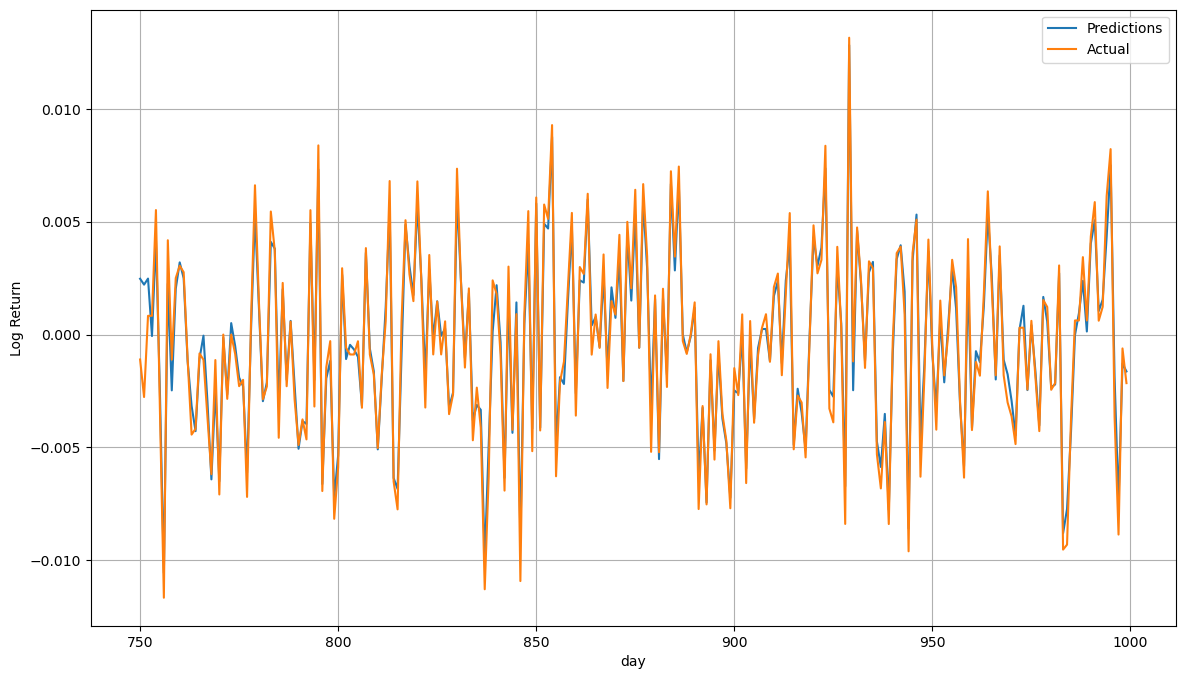

In [36]:
def plotPredictedVsActualLogReturns(predictions, actualLogReturns, instrumentIndex):
    instrumentPredictions = np.array([prediction[instrumentIndex] for prediction in predictions])
    actualInstrumentLogReturns = actualLogReturns[instrumentIndex, :]

    print(f"instrumentPredictions shape = {instrumentPredictions.shape}")
    print(f"actualInstrumentLogReturns shape = {actualInstrumentLogReturns.shape}")

    days = np.arange(750, 1000)

    plt.figure(figsize=(14, 8))
    plt.plot(days, instrumentPredictions, label = "Predictions")
    plt.plot(days, actualInstrumentLogReturns, label = "Actual")
    plt.xlabel("day")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

actualLogReturns = np.log(prices1000Days[:, 750:] / prices1000Days[:, 749:-1])

plotPredictedVsActualLogReturns(predictions, actualLogReturns, 0)